Thanks for:

These notebooks: https://www.kaggle.com/maunish/osic-super-cool-eda-and-pytorch-baseline#6-Simple-Pytorch-Model
https://www.kaggle.com/carlossouza/bayesian-experiments


In [1]:
# v10  fied submission bug

In [2]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [3]:
import albumentations
import copy
import cv2
#import gdcm
#import dicom

from efficientnet_pytorch import model as enet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import pydicom
import pymc3 as pm

import random

import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from skimage import exposure

import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

print("PyTorch Version: ",torch.__version__)
print(f"sklern: {sklearn.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.1
sklern: 0.23.2
cpu


# Config

In [4]:
n_epochs = 9999
train_bs = 32
valid_bs = 32
test_bs = 16

SIZE = 256
Learning_rate = 0.1

In [5]:
data_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/"

train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
submission2 = submission.copy()

train_image_folder = os.path.join(data_dir+'train')
test_image_folder = os.path.join(data_dir+'test')

kernel_type = 'train_effnet_b0'
enet_type = 'efficientnet-b0'
ID = 'Patient_Week'

In [6]:
submission2

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100
...,...,...,...
725,ID00419637202311204720264_133,2000,100
726,ID00421637202311550012437_133,2000,100
727,ID00422637202311677017371_133,2000,100
728,ID00423637202312137826377_133,2000,100


In [7]:
random_seed = 42

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(random_seed)

# CT images extraction

In [8]:
#https://www.kaggle.com/unforgiven/osic-comprehensive-eda

import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
from scipy.stats import describe

def load_scan(dicom_dir):
  files = os.listdir(dicom_dir)  
  files.sort(key=lambda x: (int(x[:-4]), x[:-3]))
  dcms = []
  len_files = len(files)

  if len_files < 15:
    Point = 2*len(files)//10+2
    dicom_file = os.path.join(dicom_dir, files[Point])
    dcms.append(dicom_file)

  elif len_files < 33: # 25% percentile
    Point = 3*len(files)//10
    Range = 3
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)

  elif len_files > 500: # 75% percentile
    Point = 6*len(files)//10
    Range = 7
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
  else:
    Point = 4*len(files)//10
    Range = 5
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
      
  slices = []
  for scan in  dcms:
        with pydicom.dcmread(scan) as s:
            slices.append(s)
    
  slices.sort(key = lambda x: int(x.InstanceNumber))

  try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    
  for s in slices:
        s.SliceThickness = slice_thickness
        
  return slices

def get_pixels_hu(slices):
    imags = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    imags = imags.astype(np.int16)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    if slices[0].RescaleIntercept == -1024:
       imags[imags <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    center = slices[0].WindowCenter

    try:thresh = center*0.9
    except:thresh = center[0]*0.9
    
    if slope != 1:
        imags = slope * image.astype(np.float64)
        imags = image.astype(np.int16)
        
    imags += np.int16(intercept)

    imags = np.array(imags, dtype=np.int16)


    binaries = []
    for imag in imags:
      binary = imag <= thresh
      binaries.append(binary)
    mean_img = np.mean(binaries, axis=0)
    
    return mean_img

def conv_img(mean_img):
  h, w = mean_img.shape[:2]
  if h == w:
    h1, h2 = int(h * 0.33), int(h * 0.7)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h > w:
    a, b = h/w, w/h
    h1, h2 = int(h * 0.3*a), int(h * 0.7*b)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h < w:
    a, b = w/h, h/w
    h1, h2 = int(h * 0.4), int(h * 0.67)
    w1, w2 = int(w * 0.3*a), int(w * 0.8*b)
    

  mean_img = mean_img[h1: h2, w1: w2]
  mean_img = cv2.resize(mean_img, (SIZE, SIZE))

  stacked_img = np.stack((mean_img,)*3, -1)
  stacked_img = exposure.equalize_adapthist(stacked_img)
  

  return stacked_img

In [9]:
from collections import defaultdict

data_dic = defaultdict()

for pt_id in tqdm(set(list(test.Patient))):
  dicom_dir = os.path.join(test_image_folder, pt_id)
  patient = load_scan(dicom_dir)
  mean_img = get_pixels_hu(patient)
  stacked_img = conv_img(mean_img)
  data_dic[dicom_dir]=stacked_img

# Dataset

In [10]:
class OsciDataset(Dataset):
    
  def __init__(self, image_paths, data_dic, targets, augmentations=None, meta_features = None):
      """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
      """
      self.image_paths = image_paths
      self.data_dic = data_dic
      self.targets = targets
      self.augmentations = augmentations
      self.meta_features = meta_features

  def __len__(self):
      return len(self.image_paths)

  def get_targets(self):
      return list(self.targets)

  def __getitem__(self, idx):
      img = self.data_dic[self.image_paths[idx]]
      
      if self.augmentations is not None:
          augmented = self.augmentations(image=img)
          img = augmented["image"]
            
      if self.meta_features is not None:
        meta = self.meta_features[idx]
        meta = torch.tensor(meta)
        
      stacked_img = img.transpose(2, 0, 1)
      
      targets = self.targets[idx]

      return {
            "image": (torch.tensor(stacked_img), meta),
            "targets": torch.tensor(targets),
        }

# Augmentations

In [11]:
valid_aug = albumentations.Compose([])

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


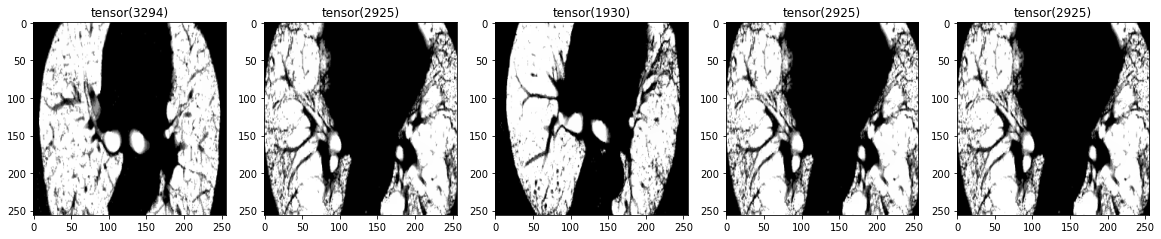

In [12]:
tmp_pt_id = test.Patient.values.tolist()
tmp_images_dir = [os.path.join(test_image_folder, tmp_pt_id[i]) for i in range(len(tmp_pt_id))]
tmp_targets = test.FVC.values
tmp_meta = np.array(test['Weeks'].values, dtype=np.float32)

dataset_show = OsciDataset(image_paths = tmp_images_dir, data_dic=data_dic, targets=tmp_targets, augmentations=valid_aug, meta_features = tmp_meta)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

fig, axes = plt.subplots(1, 5)
for i in range(5):
  idx = np.random.randint(0, len(dataset_show))
  data = dataset_show[idx]
  imag, _ = data["image"]
  print(imag.shape)
  axes[i].imshow(imag.transpose(0, 1).transpose(1, 2).squeeze())
  axes[i].set_title(data["targets"])

# Model

In [13]:
class MyBatchNorm1d(nn.BatchNorm1d):
    def __init__(self, *kargs, **kwargs):
        super(MyBatchNorm1d, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        self.running_var.data = torch.round(self.running_var.data)
        
        out = F.batch_norm(input, self.running_mean, self.running_var,self.weight, self.bias, self.training, self.momentum, self.eps)
        
        return out

In [14]:
class enetv2(nn.Module):
    def __init__(self, backbone, n_features: int):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        #self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        
        self.cnn = nn.Sequential(nn.Linear(self.enet._fc.in_features, 250, bias=True),
                                 MyBatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1)
                                 )

        self.meta = nn.Sequential(nn.Linear(n_features, 500, bias=True),
                                  MyBatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25),
                                  nn.Linear(500, 250),  
                                  MyBatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25)
                                  )
        
        self.enet._fc = nn.Identity()
        self.out = nn.Linear(250 + 250, 3)
        
    def extract(self, x):
        return self.enet(x)

    def forward(self, inputs):
        x, meta = inputs
        x = self.extract(x)
        x = self.cnn(x)
        meta = self.meta(meta)
        x = torch.cat((x, meta), 1)
        out = self.out(x)
        
        return out

In [15]:
model_files = []

for file in os.listdir("../input/oscitrainedmodels/"):
    if ".pth" in file:
        model_files.append(file)
model_files

['20200930_v14_train_effnet_b0_best_fold2.pth',
 '20200930_v14_train_effnet_b0_best_fold1.pth']

In [16]:
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join("../input/oscitrainedmodels", model_f)
        backbone = 'efficientnet-b0'
        n_features = 214
        model = enetv2(backbone, n_features)
        model.load_state_dict(torch.load(model_f, map_location=lambda storage, loc: storage), strict=True)
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

In [17]:
models = load_models(model_files)

../input/oscitrainedmodels/20200930_v14_train_effnet_b0_best_fold2.pth loaded!
../input/oscitrainedmodels/20200930_v14_train_effnet_b0_best_fold1.pth loaded!


# Create testset data with Bayesian approach

https://colab.research.google.com/drive/13WTKUlpYEtN0RNhzax_j8gbf84FuU1CF?authuser=1#scrollTo=jUeafaYrv9Em

In [18]:
tr = train.copy()
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11
...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,ID00426637202313170790466_13
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,ID00426637202313170790466_19
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,ID00426637202313170790466_31
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,ID00426637202313170790466_43


In [19]:
output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train


(12144, 11)


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21
...,...,...,...,...,...,...,...,...,...,...,...
12139,ID00426637202313170790466,11,2976,ID00426637202313170790466_11,59,2774,68.117081,73,Male,Never smoked,-48
12140,ID00426637202313170790466,13,2712,ID00426637202313170790466_13,59,2774,68.117081,73,Male,Never smoked,-46
12141,ID00426637202313170790466,19,2978,ID00426637202313170790466_19,59,2774,68.117081,73,Male,Never smoked,-40
12142,ID00426637202313170790466,31,2908,ID00426637202313170790466_31,59,2774,68.117081,73,Male,Never smoked,-28


In [20]:
# PercentをFVCに合わせて補正
# X * Percent / 100 = FVC
# X = FVC * 100 / Percent

dic = {}
for i in range(len(test)):
    X = int(test.FVC[i]*100/test.Percent[i])
    dic[test.Patient[i]] = X
dic

{'ID00419637202311204720264': 4302,
 'ID00421637202311550012437': 3338,
 'ID00422637202311677017371': 2517,
 'ID00423637202312137826377': 4156,
 'ID00426637202313170790466': 4072}

In [21]:
ts = test.copy()
tr = pd.concat([tr, ts], axis=0, ignore_index=True).drop_duplicates()
le_id = LabelEncoder()
tr['PatientID'] = le_id.fit_transform(tr['Patient'])

In [22]:
n_patients = tr['Patient'].nunique()
FVC_obs = tr['FVC'].values
Weeks = tr['Weeks'].values
PatientID = tr['PatientID'].values

with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

In [23]:
pred_template = []
for p in tｓ['Patient'].unique():
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = p
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)
pred_template['PatientID'] = le_id.transform(pred_template['Patient'])

with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [24]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'Patient_Week', 'FVC', 'Confidence'])
df['Patient'] = pred_template['Patient']
df['Weeks'] = pred_template['Weeks']
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df['FVC'] = post_pred['FVC_like'].T.mean(axis=1)
df['Confidence'] = post_pred['FVC_like'].T.std(axis=1)
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2867.661386,162.483484
1,ID00419637202311204720264_-11,2870.346891,162.487260
2,ID00419637202311204720264_-10,2864.960188,158.986447
3,ID00419637202311204720264_-9,2859.027769,156.728646
4,ID00419637202311204720264_-8,2858.710315,159.027809
...,...,...,...
725,ID00426637202313170790466_129,2713.541328,281.048902
726,ID00426637202313170790466_130,2717.872827,278.869184
727,ID00426637202313170790466_131,2715.517531,281.325573
728,ID00426637202313170790466_132,2711.163255,288.061208


In [25]:
test = test.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
print(test.shape)
test

(730, 10)


,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,2925,71.824968,73,Male,Never smoked,129
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,2925,71.824968,73,Male,Never smoked,130
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,2925,71.824968,73,Male,Never smoked,131
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,2925,71.824968,73,Male,Never smoked,132


### Reassign the predicted FVC

In [26]:
test = test.drop(columns='base_FVC').merge(final[["Patient_Week", "FVC"]], on='Patient_Week')
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,70.186855,73,Male,Ex-smoker,-18,2867.661386
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,70.186855,73,Male,Ex-smoker,-17,2870.346891
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,70.186855,73,Male,Ex-smoker,-16,2864.960188
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,70.186855,73,Male,Ex-smoker,-15,2859.027769
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,70.186855,73,Male,Ex-smoker,-14,2858.710315
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,71.824968,73,Male,Never smoked,129,2713.541328
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,71.824968,73,Male,Never smoked,130,2717.872827
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,71.824968,73,Male,Never smoked,131,2715.517531
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,71.824968,73,Male,Never smoked,132,2711.163255


In [27]:
# Percent = FVC * 100 /X

for i in range(len(test)):
    Percent = test.FVC[i]*100 / dic[test.Patient[i]]
    test.base_Percent[i] = Percent
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.658796,73,Male,Ex-smoker,-18,2867.661386
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.721220,73,Male,Ex-smoker,-17,2870.346891
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.596006,73,Male,Ex-smoker,-16,2864.960188
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.458107,73,Male,Ex-smoker,-15,2859.027769
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.450728,73,Male,Ex-smoker,-14,2858.710315
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.639031,73,Male,Never smoked,129,2713.541328
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.745403,73,Male,Never smoked,130,2717.872827
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.687562,73,Male,Never smoked,131,2715.517531
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.580630,73,Male,Never smoked,132,2711.163255


# Create meta featuers

In [28]:
#getting FVC for base week and setting it as base_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    df['min_week'] = df.groupby('Patient')['predict_Week'].transform('min')
    base = df.loc[df.predict_Week == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df 

#For Inference
#getting Number of CT 
def get_N_CT(data, mode="test"):
    df = data.copy()
    N_CT = []
    for pt_id in df.Patient:
      if mode is "test":
        png_dir = os.path.join(test_image_folder, pt_id)
      if mode is "train":
        png_dir = os.path.join(train_image_folder, pt_id)
      files = os.listdir(png_dir)
      N_CT.append(len(files))
    df["N_CT"] = N_CT
    return df

# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-8
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [29]:
test["min_Weeks"] = np.nan
test = get_base_FVC(test)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,min_Weeks,min_week,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.658796,73,Male,Ex-smoker,-18,2867.661386,NaN,-12,2867.661386
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.721220,73,Male,Ex-smoker,-17,2870.346891,NaN,-12,2867.661386
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.596006,73,Male,Ex-smoker,-16,2864.960188,NaN,-12,2867.661386
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.458107,73,Male,Ex-smoker,-15,2859.027769,NaN,-12,2867.661386
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.450728,73,Male,Ex-smoker,-14,2858.710315,NaN,-12,2867.661386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.639031,73,Male,Never smoked,129,2713.541328,NaN,-12,2951.874118
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.745403,73,Male,Never smoked,130,2717.872827,NaN,-12,2951.874118
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.687562,73,Male,Never smoked,131,2715.517531,NaN,-12,2951.874118
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.580630,73,Male,Never smoked,132,2711.163255,NaN,-12,2951.874118


In [30]:
test = test.drop(['min_Weeks', 'min_week'], axis = 1)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.658796,73,Male,Ex-smoker,-18,2867.661386,2867.661386
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.721220,73,Male,Ex-smoker,-17,2870.346891,2867.661386
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.596006,73,Male,Ex-smoker,-16,2864.960188,2867.661386
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.458107,73,Male,Ex-smoker,-15,2859.027769,2867.661386
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.450728,73,Male,Ex-smoker,-14,2858.710315,2867.661386
...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.639031,73,Male,Never smoked,129,2713.541328,2951.874118
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.745403,73,Male,Never smoked,130,2717.872827,2951.874118
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.687562,73,Male,Never smoked,131,2715.517531,2951.874118
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.580630,73,Male,Never smoked,132,2711.163255,2951.874118


In [31]:
train = get_N_CT(train, "train")
test = get_N_CT(test)

In [32]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)

data = data.reset_index(drop=True)
Splitdata=data['WHERE']
data = data.drop(columns='WHERE')

data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30
...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,Male,Never smoked,129,408
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,Male,Never smoked,130,408
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,Male,Never smoked,131,408
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,Male,Never smoked,132,408


In [33]:
Encoding = {"Currently smokes": 2, "Ex-smoker": 1, "Never smoked": 0, "Male": 1, "Female":0}
data['SmokingStatus'] = data.SmokingStatus.map(Encoding)
data["Sex"] = data.Sex.map(Encoding)

In [34]:
data['week'] = (data['Week_passed'] - data['Week_passed'].min() ) / ( data['Week_passed'].max() - data['Week_passed'].min())
data['percent'] = (data['base_Percent'] - data['base_Percent'].min() ) / (data['base_Percent'].max() - data['base_Percent'].min())

In [35]:
data['base_ｆｖｃ'] = (data['base_FVC'] - data['base_FVC'].min() ) / (data['base_FVC'].max() - data['base_FVC'].min())

In [36]:
Age = []
for i in range(len(data)):
  Pt_base_age = data.base_Age[data.Patient == data.Patient[i]].min()
  # 365/7 = 52.14
  # 1/52.14 = 0.01917
  Pt_age = 0.0192*data.predict_Week[i] + Pt_base_age
  Age.append(Pt_age)

data["Age"] = Age
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,week,percent,base_ｆｖｃ,Age
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,9,30,0.367347,0.236393,0.267050,79.0960
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,11,30,0.377551,0.236393,0.267050,79.1344
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,13,30,0.387755,0.236393,0.267050,79.1728
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,15,30,0.397959,0.236393,0.267050,79.2112
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,21,30,0.428571,0.236393,0.267050,79.3264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,129,408,0.979592,0.303872,0.381349,75.4768
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,130,408,0.984694,0.304728,0.381349,75.4960
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,131,408,0.989796,0.304262,0.381349,75.5152
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,132,408,0.994898,0.303402,0.381349,75.5344


In [37]:
data['age'] = (data['Age'] - data['Age'].min() ) / (data['Age'].max() - data['Age'].min())

In [38]:
# typical_FVC_cluster
fvc_cluster = {}

set_fvc = sorted(list(set(round(data.FVC/data.base_Percent*100, -2))))
for idx, fvc in enumerate(set_fvc, 1):
  fvc_cluster[fvc] = idx
fvc_cluster


{1000.0: 1,
 1200.0: 2,
 1300.0: 3,
 1400.0: 4,
 1500.0: 5,
 1600.0: 6,
 1700.0: 7,
 1800.0: 8,
 1900.0: 9,
 2000.0: 10,
 2100.0: 11,
 2200.0: 12,
 2300.0: 13,
 2400.0: 14,
 2500.0: 15,
 2600.0: 16,
 2700.0: 17,
 2800.0: 18,
 2900.0: 19,
 3000.0: 20,
 3100.0: 21,
 3200.0: 22,
 3300.0: 23,
 3400.0: 24,
 3500.0: 25,
 3600.0: 26,
 3700.0: 27,
 3800.0: 28,
 3900.0: 29,
 4000.0: 30,
 4100.0: 31,
 4200.0: 32,
 4300.0: 33,
 4400.0: 34,
 4500.0: 35,
 4600.0: 36,
 4700.0: 37,
 4800.0: 38,
 4900.0: 39,
 5000.0: 40,
 5100.0: 41,
 5200.0: 42,
 5300.0: 43,
 5400.0: 44,
 5500.0: 45,
 5600.0: 46,
 5700.0: 47,
 5800.0: 48,
 5900.0: 49,
 6000.0: 50,
 6100.0: 51,
 6200.0: 52,
 6300.0: 53,
 6400.0: 54,
 6500.0: 55,
 6600.0: 56,
 6700.0: 57,
 6800.0: 58,
 6900.0: 59,
 7000.0: 60}

In [39]:
typical_FVC_cluster = []
for i in range(len(data)):
  typical_FVC = round(data.FVC[i]/data.base_Percent[i]*100, -2)
  typical_FVC_cluster.append(fvc_cluster[typical_FVC])

data["typical_FVC_cluster"] = typical_FVC_cluster
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,week,percent,base_ｆｖｃ,Age,age,typical_FVC_cluster
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,9,30,0.367347,0.236393,0.267050,79.0960,0.739053,28
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,11,30,0.377551,0.236393,0.267050,79.1344,0.740007,25
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,13,30,0.387755,0.236393,0.267050,79.1728,0.740962,27
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,15,30,0.397959,0.236393,0.267050,79.2112,0.741916,26
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,21,30,0.428571,0.236393,0.267050,79.3264,0.744780,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,129,408,0.979592,0.303872,0.381349,75.4768,0.649087,31
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,130,408,0.984694,0.304728,0.381349,75.4960,0.649564,31
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,131,408,0.989796,0.304262,0.381349,75.5152,0.650042,31
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,132,408,0.994898,0.303402,0.381349,75.5344,0.650519,31


In [40]:
# log transform
data["N_CT"] = np.log1p(data.N_CT)
data["log_baseline_week"] = np.log1p(data.predict_Week) 
data["log_base_FVC"] = np.log1p(data.base_FVC) 
data["log_Week_passed"] = np.log1p(data.Week_passed) 


In [41]:
tmp1 = CreateFeat(data[["log_base_FVC", "Age"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Crated 4 columns



Removed 15 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,percent,base_ｆｖｃ,Age,age,typical_FVC_cluster,log_baseline_week,log_base_FVC,log_Week_passed,Age_log_base_FVC_prd,Age_log_base_FVC_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,0.236393,0.267050,79.0960,0.739053,28,1.791759,7.747597,2.302585,612.803920,10.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,0.236393,0.267050,79.1344,0.740007,25,2.079442,7.747597,2.484907,613.101427,10.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,0.236393,0.267050,79.1728,0.740962,27,2.302585,7.747597,2.639057,613.398935,10.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,0.236393,0.267050,79.2112,0.741916,26,2.484907,7.747597,2.772589,613.696443,10.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,0.236393,0.267050,79.3264,0.744780,26,2.890372,7.747597,3.091042,614.588966,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,0.303872,0.381349,75.4768,0.649087,31,4.867534,7.990534,4.867534,603.099956,9.0
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,0.304728,0.381349,75.4960,0.649564,31,4.875197,7.990534,4.875197,603.253374,9.0
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,0.304262,0.381349,75.5152,0.650042,31,4.882802,7.990534,4.882802,603.406792,9.0
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,0.303402,0.381349,75.5344,0.650519,31,4.890349,7.990534,4.890349,603.560210,9.0


In [42]:
tmp1 = CreateFeat(data[["N_CT", "base_FVC"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Crated 4 columns



Removed 17 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,Age,age,typical_FVC_cluster,log_baseline_week,log_base_FVC,log_Week_passed,Age_log_base_FVC_prd,Age_log_base_FVC_div,base_FVC_N_CT_prd,base_FVC_N_CT_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,79.0960,0.739053,28,1.791759,7.747597,2.302585,612.803920,10.0,7949.680378,674.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,79.1344,0.740007,25,2.079442,7.747597,2.484907,613.101427,10.0,7949.680378,674.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,79.1728,0.740962,27,2.302585,7.747597,2.639057,613.398935,10.0,7949.680378,674.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,79.2112,0.741916,26,2.484907,7.747597,2.772589,613.696443,10.0,7949.680378,674.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,79.3264,0.744780,26,2.890372,7.747597,3.091042,614.588966,10.0,7949.680378,674.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,75.4768,0.649087,31,4.867534,7.990534,4.867534,603.099956,9.0,17751.730121,491.0
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,75.4960,0.649564,31,4.875197,7.990534,4.875197,603.253374,9.0,17751.730121,491.0
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,75.5152,0.650042,31,4.882802,7.990534,4.882802,603.406792,9.0,17751.730121,491.0
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,75.5344,0.650519,31,4.890349,7.990534,4.890349,603.560210,9.0,17751.730121,491.0


In [43]:
tmp1 = CreateFeat(data[["base_FVC", "age"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Crated 4 columns



Removed 19 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster,log_baseline_week,log_base_FVC,log_Week_passed,Age_log_base_FVC_prd,Age_log_base_FVC_div,base_FVC_N_CT_prd,base_FVC_N_CT_div,base_FVC_age_div,age_base_FVC_prd
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,28,1.791759,7.747597,2.302585,612.803920,10.0,7949.680378,674.0,3132.0,1710.906813
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,25,2.079442,7.747597,2.484907,613.101427,10.0,7949.680378,674.0,3128.0,1713.116573
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,27,2.302585,7.747597,2.639057,613.398935,10.0,7949.680378,674.0,3124.0,1715.326333
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,26,2.484907,7.747597,2.772589,613.696443,10.0,7949.680378,674.0,3120.0,1717.536094
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,26,2.890372,7.747597,3.091042,614.588966,10.0,7949.680378,674.0,3108.0,1724.165374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,31,4.867534,7.990534,4.867534,603.099956,9.0,17751.730121,491.0,4548.0,1916.023768
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,31,4.875197,7.990534,4.875197,603.253374,9.0,17751.730121,491.0,4544.0,1917.432609
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,31,4.882802,7.990534,4.882802,603.406792,9.0,17751.730121,491.0,4541.0,1918.841450
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,31,4.890349,7.990534,4.890349,603.560210,9.0,17751.730121,491.0,4538.0,1920.250291


In [44]:
tmp1 = CreateFeat(data[["log_baseline_week", "base_FVC"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Crated 4 columns



Removed 0 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,Age_log_base_FVC_prd,Age_log_base_FVC_div,base_FVC_N_CT_prd,base_FVC_N_CT_div,base_FVC_age_div,age_base_FVC_prd,log_baseline_week_base_FVC_prd,log_baseline_week_base_FVC_div,base_FVC_log_baseline_week_prd,base_FVC_log_baseline_week_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,612.803920,10.0,7949.680378,674.0,3132.0,1710.906813,4147.923171,0.0,4147.923171,1292.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,613.101427,10.0,7949.680378,674.0,3128.0,1713.116573,4813.907169,0.0,4813.907169,1113.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,613.398935,10.0,7949.680378,674.0,3124.0,1715.326333,5330.484490,0.0,5330.484490,1005.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,613.696443,10.0,7949.680378,674.0,3120.0,1717.536094,5752.558894,0.0,5752.558894,932.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,614.588966,10.0,7949.680378,674.0,3108.0,1724.165374,6691.210620,0.0,6691.210620,801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,603.099956,9.0,17751.730121,491.0,4548.0,1916.023768,14368.348962,0.0,14368.348962,606.0
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,603.253374,9.0,17751.730121,491.0,4544.0,1917.432609,14390.968797,0.0,14390.968797,605.0
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,603.406792,9.0,17751.730121,491.0,4541.0,1918.841450,14413.416617,0.0,14413.416617,605.0
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,603.560210,9.0,17751.730121,491.0,4538.0,1920.250291,14435.695018,0.0,14435.695018,604.0


In [45]:
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")#, "skew","kurt")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

tmp = CreateFeat2(data[["base_FVC", "base_FVC_age_div", "age", "age_base_FVC_prd", "Age_log_base_FVC_prd", "log_base_FVC", "base_FVC_N_CT_div", "log_baseline_week", "typical_FVC_cluster", "Week_passed"]])

data = pd.concat([data, tmp], axis=1)
data= data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp], axis=1)

data

0/7: Calucurating... max


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 630 columns



Removed 400 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster_log_baseline_week_std,Week_passed_base_FVC_std,Week_passed_base_FVC_age_div_std,Week_passed_age_std,Week_passed_age_base_FVC_prd_std,Week_passed_Age_log_base_FVC_prd_std,Week_passed_log_base_FVC_std,Week_passed_base_FVC_N_CT_div_std,Week_passed_log_baseline_week_std,Week_passed_typical_FVC_cluster_std
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,18.532025,1630.588237,2208.294478,5.841372,1203.429848,426.953846,0.885583,470.226009,5.096996,13.435029
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,16.207282,1629.174024,2204.051837,7.254911,1203.578171,425.750002,2.299796,468.811796,6.307787,9.899495
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,17.463710,1627.759810,2199.809196,8.668449,1203.726494,424.546158,3.714010,467.397582,7.564215,9.899495
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,16.627682,1626.345597,2195.566556,10.081988,1203.874817,423.342315,5.128223,465.983369,8.849507,7.778175
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,16.340975,1622.102956,2182.838634,14.322604,1204.319785,419.730783,9.370864,461.740728,12.805441,3.535534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,18.478444,1996.073431,3124.704866,90.757801,1263.616625,335.239294,85.566614,255.972655,87.774908,69.296465
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,18.473025,1995.366324,3121.169332,91.464570,1263.905719,334.640670,86.273721,255.265548,88.476596,70.003571
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,18.467648,1994.659218,3118.340905,92.171339,1264.194813,334.042046,86.980827,254.558441,89.178326,70.710678
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,18.462311,1993.952111,3115.512478,92.878109,1264.483907,333.443423,87.687934,253.851334,89.880096,71.417785


In [46]:
# clipping
clipping = data.columns[10:]
for col in clipping:
  upperbound, lowerbound = np.percentile(data[col], [1, 99])
  data[col] = np.clip(data[col], upperbound, lowerbound)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:7203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[mask] = np.nan


In [47]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster_log_base_FVC_std,typical_FVC_cluster_base_FVC_N_CT_div_std,Week_passed_base_FVC_std,Week_passed_base_FVC_age_div_std,Week_passed_age_std,Week_passed_age_base_FVC_prd_std,Week_passed_Age_log_base_FVC_prd_std,Week_passed_log_base_FVC_std,Week_passed_base_FVC_N_CT_div_std,Week_passed_typical_FVC_cluster_std
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,14.320612,456.790981,1630.588237,2208.294478,5.841372,1203.429848,426.953846,0.885583,470.226009,13.435029
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,12.199291,458.912301,1629.174024,2204.051837,7.254911,1203.578171,425.750002,2.299796,468.811796,9.899495
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,13.613505,457.498087,1627.759810,2199.809196,8.668449,1203.726494,424.546158,3.714010,467.397582,9.899495
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,12.906398,458.205194,1626.345597,2195.566556,10.081988,1203.874817,423.342315,5.128223,465.983369,7.778175
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,12.906398,458.205194,1622.102956,2182.838634,14.322604,1204.319785,419.730783,9.370864,461.740728,3.535534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,16.270149,325.269119,1996.073431,3124.704866,69.553244,1263.616625,335.239294,64.358934,255.972655,64.346717
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,16.270149,325.269119,1995.366324,3121.169332,69.553244,1263.905719,334.640670,64.358934,255.265548,64.346717
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,16.270149,325.269119,1994.659218,3118.340905,69.553244,1264.194813,334.042046,64.358934,254.558441,64.346717
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,16.270149,325.269119,1993.952111,3115.512478,69.553244,1264.483907,333.443423,64.358934,253.851334,64.346717


# Prediction

In [48]:
data['WHERE'] = Splitdata
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster_base_FVC_N_CT_div_std,Week_passed_base_FVC_std,Week_passed_base_FVC_age_div_std,Week_passed_age_std,Week_passed_age_base_FVC_prd_std,Week_passed_Age_log_base_FVC_prd_std,Week_passed_log_base_FVC_std,Week_passed_base_FVC_N_CT_div_std,Week_passed_typical_FVC_cluster_std,WHERE
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,456.790981,1630.588237,2208.294478,5.841372,1203.429848,426.953846,0.885583,470.226009,13.435029,train
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,458.912301,1629.174024,2204.051837,7.254911,1203.578171,425.750002,2.299796,468.811796,9.899495,train
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,457.498087,1627.759810,2199.809196,8.668449,1203.726494,424.546158,3.714010,467.397582,9.899495,train
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,458.205194,1626.345597,2195.566556,10.081988,1203.874817,423.342315,5.128223,465.983369,7.778175,train
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,458.205194,1622.102956,2182.838634,14.322604,1204.319785,419.730783,9.370864,461.740728,3.535534,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,325.269119,1996.073431,3124.704866,69.553244,1263.616625,335.239294,64.358934,255.972655,64.346717,test
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,325.269119,1995.366324,3121.169332,69.553244,1263.905719,334.640670,64.358934,255.265548,64.346717,test
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,325.269119,1994.659218,3118.340905,69.553244,1264.194813,334.042046,64.358934,254.558441,64.346717,test
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,325.269119,1993.952111,3115.512478,69.553244,1264.483907,333.443423,64.358934,253.851334,64.346717,test


In [49]:
# clean up column names with a simple instruction
# https://stackoverflow.com/questions/60698860/how-to-deal-with-do-not-support-non-ascii-characters-in-feature-name-error-whe
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster_base_FVC_N_CT_div_std,Week_passed_base_FVC_std,Week_passed_base_FVC_age_div_std,Week_passed_age_std,Week_passed_age_base_FVC_prd_std,Week_passed_Age_log_base_FVC_prd_std,Week_passed_log_base_FVC_std,Week_passed_base_FVC_N_CT_div_std,Week_passed_typical_FVC_cluster_std,WHERE
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,456.790981,1630.588237,2208.294478,5.841372,1203.429848,426.953846,0.885583,470.226009,13.435029,train
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,458.912301,1629.174024,2204.051837,7.254911,1203.578171,425.750002,2.299796,468.811796,9.899495,train
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,457.498087,1627.759810,2199.809196,8.668449,1203.726494,424.546158,3.714010,467.397582,9.899495,train
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,458.205194,1626.345597,2195.566556,10.081988,1203.874817,423.342315,5.128223,465.983369,7.778175,train
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,458.205194,1622.102956,2182.838634,14.322604,1204.319785,419.730783,9.370864,461.740728,3.535534,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2713.541328,ID00426637202313170790466_129,0,2951.874118,66.639031,73,1,0,...,325.269119,1996.073431,3124.704866,69.553244,1263.616625,335.239294,64.358934,255.972655,64.346717,test
12870,ID00426637202313170790466,130,2717.872827,ID00426637202313170790466_130,0,2951.874118,66.745403,73,1,0,...,325.269119,1995.366324,3121.169332,69.553244,1263.905719,334.640670,64.358934,255.265548,64.346717,test
12871,ID00426637202313170790466,131,2715.517531,ID00426637202313170790466_131,0,2951.874118,66.687562,73,1,0,...,325.269119,1994.659218,3118.340905,69.553244,1264.194813,334.042046,64.358934,254.558441,64.346717,test
12872,ID00426637202313170790466,132,2711.163255,ID00426637202313170790466_132,0,2951.874118,66.580630,73,1,0,...,325.269119,1993.952111,3115.512478,69.553244,1264.483907,333.443423,64.358934,253.851334,64.346717,test


In [50]:
train = data[data['WHERE']=="train"]
test = data[data['WHERE']=="test"]
sub = test.copy()
train

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,typical_FVC_cluster_base_FVC_N_CT_div_std,Week_passed_base_FVC_std,Week_passed_base_FVC_age_div_std,Week_passed_age_std,Week_passed_age_base_FVC_prd_std,Week_passed_Age_log_base_FVC_prd_std,Week_passed_log_base_FVC_std,Week_passed_base_FVC_N_CT_div_std,Week_passed_typical_FVC_cluster_std,WHERE
0,ID00007637202177411956430,5,2214.0,ID00007637202177411956430_5,-4,2315.0,58.253649,79,1,1,...,456.790981,1630.588237,2208.294478,5.841372,1203.429848,426.953846,0.885583,470.226009,13.435029,train
1,ID00007637202177411956430,7,2061.0,ID00007637202177411956430_7,-4,2315.0,58.253649,79,1,1,...,458.912301,1629.174024,2204.051837,7.254911,1203.578171,425.750002,2.299796,468.811796,9.899495,train
2,ID00007637202177411956430,9,2144.0,ID00007637202177411956430_9,-4,2315.0,58.253649,79,1,1,...,457.498087,1627.759810,2199.809196,8.668449,1203.726494,424.546158,3.714010,467.397582,9.899495,train
3,ID00007637202177411956430,11,2069.0,ID00007637202177411956430_11,-4,2315.0,58.253649,79,1,1,...,458.205194,1626.345597,2195.566556,10.081988,1203.874817,423.342315,5.128223,465.983369,7.778175,train
4,ID00007637202177411956430,17,2101.0,ID00007637202177411956430_17,-4,2315.0,58.253649,79,1,1,...,458.205194,1622.102956,2182.838634,14.322604,1204.319785,419.730783,9.370864,461.740728,3.535534,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12139,ID00426637202313170790466,11,2976.0,ID00426637202313170790466_11,59,2774.0,68.117081,73,1,0,...,301.934596,1995.455337,3343.200861,34.360277,1196.666648,444.379927,39.547355,359.917352,57.982756,train
12140,ID00426637202313170790466,13,2712.0,ID00426637202313170790466_13,59,2774.0,68.117081,73,1,0,...,304.763023,1994.041123,3336.129794,32.946738,1197.124778,443.180992,38.133142,358.503138,53.740115,train
12141,ID00426637202313170790466,19,2978.0,ID00426637202313170790466_19,59,2774.0,68.117081,73,1,0,...,301.934596,1989.798482,3316.330804,28.706122,1198.499169,439.584189,33.890501,354.260497,52.325902,train
12142,ID00426637202313170790466,31,2908.0,ID00426637202313170790466_31,59,2774.0,68.117081,73,1,0,...,302.641702,1981.313201,3276.732824,20.224891,1201.247950,432.390583,25.405220,345.775216,43.133514,train


In [51]:
# Test data for inference
test_pt_id = test.Patient.values.tolist()
test_images_dir = [os.path.join(test_image_folder,test_pt_id[i]) for i in range(len(test_pt_id))]

test_targets = test.FVC.values

In [52]:
test.columns[5:-1]

Index(['base_FVC', 'base_Percent', 'base_Age', 'Sex', 'SmokingStatus', 'N_CT',
       'week', 'percent', 'base_', 'Age',
       ...
       'typical_FVC_cluster_log_base_FVC_std',
       'typical_FVC_cluster_base_FVC_N_CT_div_std', 'Week_passed_base_FVC_std',
       'Week_passed_base_FVC_age_div_std', 'Week_passed_age_std',
       'Week_passed_age_base_FVC_prd_std',
       'Week_passed_Age_log_base_FVC_prd_std', 'Week_passed_log_base_FVC_std',
       'Week_passed_base_FVC_N_CT_div_std',
       'Week_passed_typical_FVC_cluster_std'],
      dtype='object', length=214)

In [53]:
#Preprocessing
meta_col = test.columns[5:-1]
scaler = StandardScaler()

test = test[meta_col]
test_meta= scaler.fit_transform(test)  
test_meta = np.array(test_meta, dtype=np.float32)

test_dataset = OsciDataset(
    image_paths=test_images_dir,
    data_dic=data_dic,
    targets=test_targets,
    augmentations=valid_aug,
    meta_features=test_meta
    )

test_loader = torch.utils.data.DataLoader(
      test_dataset, 
      batch_size=test_bs, 
      shuffle=False, 
      num_workers=os.cpu_count(),
      pin_memory=True
      )

In [54]:
all_prediction = np.zeros((test.shape[0], 3))

for model in models:
    predictions = []
    with torch.no_grad():
        for data in tqdm(test_loader):
          inputs = data["image"]


          inputs[0] = inputs[0].to(device, dtype=torch.float) 
          inputs[1] = inputs[1].to(device, dtype=torch.float)
          
          outputs = model(inputs)
          predictions.extend(outputs.cpu().detach().numpy())

    all_prediction += np.array(predictions)/len(models)

In [55]:
sub = sub.reset_index(drop=True)
sub["Confidence"] = 0.0

In [56]:
sub["Confidence"] = np.abs(all_prediction[:,2] - all_prediction[:,0])
sub["FVC"] = all_prediction[:,1]
sub["FVC"] *= 0.996

In [57]:
submission2 = submission2.drop(columns=['FVC', 'Confidence'])
sub2 = submission2.merge(sub[['Patient_Week', 'FVC', 'Confidence']], on='Patient_Week')
sub2.to_csv('submission.csv', index=False)
sub2

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3133.033138,232.495361
1,ID00421637202311550012437_-12,3190.507274,268.566284
2,ID00422637202311677017371_-12,1933.222322,189.729980
3,ID00423637202312137826377_-12,3669.450872,287.734375
4,ID00426637202313170790466_-12,3472.057945,260.863770
...,...,...,...
725,ID00419637202311204720264_133,2311.267119,186.551270
726,ID00421637202311550012437_133,2775.020744,202.896118
727,ID00422637202311677017371_133,1204.805953,197.599670
728,ID00423637202312137826377_133,2225.207224,180.455811


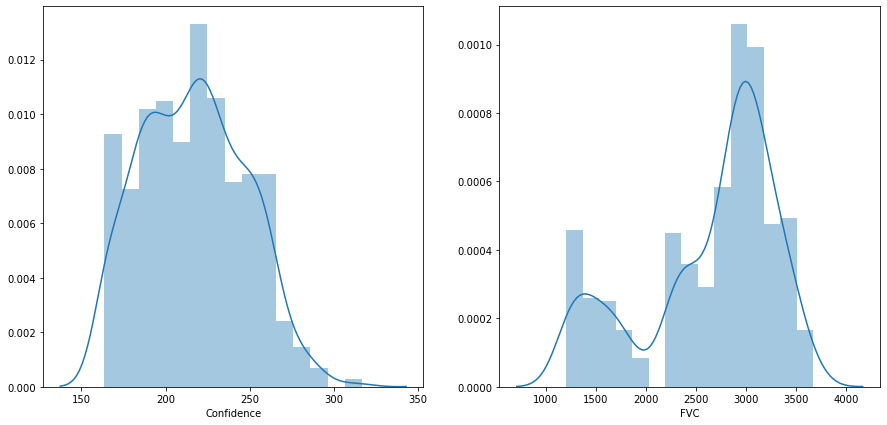

In [58]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.distplot(sub.Confidence)
plt.subplot(122)
sns.distplot(sub.FVC);

In [59]:
print(sub2.shape)
sub2

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3133.033138,232.495361
1,ID00421637202311550012437_-12,3190.507274,268.566284
2,ID00422637202311677017371_-12,1933.222322,189.729980
3,ID00423637202312137826377_-12,3669.450872,287.734375
4,ID00426637202313170790466_-12,3472.057945,260.863770
...,...,...,...
725,ID00419637202311204720264_133,2311.267119,186.551270
726,ID00421637202311550012437_133,2775.020744,202.896118
727,ID00422637202311677017371_133,1204.805953,197.599670
728,ID00423637202312137826377_133,2225.207224,180.455811


In [60]:
sub2.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2642.666588,216.558997
std,664.275015,30.834535
min,1204.805953,163.627869
25%,2315.093579,191.166794
50%,2873.239572,217.333496
75%,3100.775510,239.516174
max,3669.450872,316.711304


In [61]:
!ls

__notebook__.ipynb  submission.csv
